# Projet PYTHON  scoring

#### Réalisé par Adeniji Abudu Mederic Dorego Tanguy Hodonou

#### Professeur référent : William KENGNE

### Importation des librairies a utilisées

[[ go back to the top ]](#SOMMAIRE)


In [358]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import subplot, figure, subplots
from sklearn.impute import SimpleImputer 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz

Commençons par lire les données dans un DataFrame pandas.

In [359]:
file = "E:\AA_Master_IEAD\homework\Data_mining\Tab2.sas7bdat"
df = pd.read_sas(file,format='sas7bdat', encoding='utf-8')

On renomme les variables disponibles dans la table.

In [360]:
df.rename(columns={'varA':'incident',
                   'varB':'pret',
                   'varC':'hypotheque',
                   'varD':'propriete',
                   'varE':'motif',
                   'varF':'profession',
                   'varG':'experience',
                   'varH':'nbreport',
                   'varI':'nblitige',
                   'varJ':'agecredit',
                   'varK':'nbcredit',
                   'varL':'ratio'},
          inplace=True)

In [361]:
#on convertit la variable incident en une variable binaire
df['incident'] = df.incident.astype('int')

#Enfin nous avons transformé variable « AgeCred » qui était en mois en années.
df['agecredit'] = df['agecredit']/12

df_quanti=df[['incident', 'pret', 'hypotheque', 'propriete',
             'experience', 'nbreport', 'nblitige', 'agecredit', 
              'nbcredit','ratio']]

df_quali=df[['motif', 'profession']]

#### Imputation par la moyenne des données manquantes

[[ go back to the top ]](#SOMMAIRE)

L’imputation simple est le remplacement des données manquantes par des valeurs statistiques choisies de façon raisonnée comme nous l'avons défini précédemment. Pour les variables quantitatives nous décidons de faire une imputation par la moyenne. 

In [362]:
df_quanti_nomissing = df_quanti.apply(lambda x: x.fillna(x.mean()),axis=0)
#print(df_quanti_nomissing.isnull().sum(axis=0))

#### Imputation par le mode

[[ go back to the top ]](#SOMMAIRE)

L'imputation par le mode s'effectue uniquement sur les variables qualitatives. Dans notre cas nous disposons de deux variables qualitatives. 
Il s'agit de la variable «Motif» et la variable «Profession». Les tableaux suivants représentent les différentes modalités prises par ces variables et leurs fréquences avant et après imputation.


In [363]:
df_most_common_imputed = df_quali.apply(lambda x: x.fillna(x.value_counts().index[0]))
#print(df_most_common_imputed.isnull().sum(axis=0))

In [364]:
#table sans valeur manquante
data_credit=pd.concat([df_most_common_imputed, df_quanti_nomissing], axis=1)
#
data_credit['incident'] = np.where(df['incident']==1, 'oui', 'non')

In [365]:
# Une seule indicatrice par variable binaire
data_final = pd.get_dummies(data_credit, columns=['incident', 'motif', 'profession'], drop_first= True)
data_final.head()

,pret,hypotheque,propriete,experience,nbreport,nblitige,agecredit,nbcredit,ratio,incident_oui,motif_HomeImp,profession_Office,profession_Other,profession_ProfEx,profession_Sales,profession_Self
0,1300.0,70053.0,68400.0,7.0,0.0,2.0,10.152500,0.0,33.630728,1,1,0,1,0,0,0
1,1500.0,13500.0,16700.0,4.0,0.0,0.0,12.455833,1.0,33.630728,1,1,0,1,0,0,0
2,1700.0,97800.0,112000.0,3.0,0.0,0.0,7.777500,0.0,33.630728,0,1,1,0,0,0,0
3,1700.0,30548.0,40320.0,9.0,0.0,0.0,8.455833,1.0,37.114000,1,1,0,1,0,0,0
4,1800.0,48649.0,57037.0,5.0,3.0,2.0,6.425000,1.0,33.630728,1,1,0,1,0,0,0


## Elaboration et évaluation des modèles

[[ go back to the top ]](#SOMMAIRE)

Cette partie fera l'objet d'une part d'un problème de classification et d'autre part l'élaboration de Score comme évoqué précédemment.
La problématique prédictive de la solvabilité ou non des clients nous amène à adopter dans la suite la méthode de classification supervisée. 
Nous avons donc divisé nos données de manière aléatoire en deux parties.  2/3 pour l’échantillon d'apprentissage qui sera utilisé pour la construction des modèles et 1/3 pour l’échantillon test qui nous permettra d'évaluer les modèles.


               ▪ K-plus proches voisins
               ▪ La régression logistique
               ▪ Arbres de décision
               ▪ Forêts aléatoires

#### Extraction des échantillons apprentisage et test

In [366]:
#variables explicative
X = data_final.drop(["incident_oui"], axis=1)
#variable predictive
y = data_final["incident_oui"]
#Extraction
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)


## K-plus proches voisins

In [367]:
knn = KNeighborsClassifier(n_neighbors=10)
credit_knn=knn.fit(X_train, y_train)
# Estimation de l’erreur de prévision
# sur l’échantillon test
1-credit_knn.score(X_test,y_test)

0.1796610169491526

Optimisation du paramètre de complexité du modèle par validation croisée en
cherchant l’erreur minimale sur une grille de valeurs du paramètre avec cv=5-
fold cross validation et n_jobs=1 pour une exécution en parallèle utilisant
tous les processeurs sauf 1. Attention, comme la validation croisée est aléatoire,
deux exécutions successives ne donnent pas nécessairement le même
résultat.

In [370]:
# grille de valeurs
param=[{"n_neighbors":list(range(1,10))}]
knn= GridSearchCV(KNeighborsClassifier(),
                  param,cv=5,n_jobs=-1)
credit_knn=knn.fit(X_train, y_train)
# paramètre optimal
credit_knn.best_params_["n_neighbors"]

4

Le modèle est estimé avec la valeur "optimale" du paramètre.

In [371]:
knn_optimal = KNeighborsClassifier(n_neighbors=credit_knn.best_params_["n_neighbors"])
credit_knn_optimal=knn_optimal.fit(X_train, y_train)
# Estimation de l’erreur de prévision
1-credit_knn_optimal.score(X_test,y_test)
# Prévision
y_chap = credit_knn_optimal.predict(X_test)
# matrice de confusion
table=pd.crosstab(y_test,y_chap)
print(table)


col_0           0   1
incident_oui         
0             950  12
1             188  30


## La régression logistique

Une version Lasso de la régression logistique est testée afin d’introduire
la sélection automatique des variables.

In [376]:
logit = LogisticRegression(solver='liblinear')
credit_logit=logit.fit(X_train, y_train)
# Erreur
credit_logit.score(X_test, y_test)
# Coefficients
credit_logit.coef_

array([[-2.38061597e-05, -4.36224926e-06,  1.44347153e-06,
        -1.08762288e-02,  4.19800536e-03,  6.76610903e-03,
        -3.08618510e-02,  4.47038188e-03, -4.31660409e-03,
        -1.71010920e-05, -6.95800694e-04, -1.67793029e-04,
        -3.19253475e-04,  9.65948469e-05,  2.06531470e-04]])

In [377]:
# grille de valeurs
param=[{"C":[0.01,0.05,0.1,0.15,1,10]}]
logit = GridSearchCV(LogisticRegression(solver='liblinear'),param,cv=5)
credit_logit=logit.fit(X_train, y_train)

In [378]:
#parametre optimal
credit_logit.best_params_["C"]

0.01

In [379]:
#Utilisation de la valeur "optimale".
logit_optimal = LogisticRegression(solver = 'liblinear', C=credit_logit.best_params_["C"])
credit_logit_optimal=logit_optimal.fit(X_train, y_train)
#Erreur
credit_logit_optimal.score(X_test, y_test)
#coefficients
print(credit_logit_optimal.coef_, credit_logit_optimal.intercept_)

[[-2.38072912e-05 -4.36253423e-06  1.44340291e-06 -1.08758802e-02
   4.19823709e-03  6.76650686e-03 -3.08619726e-02  4.47064731e-03
  -4.31508991e-03 -1.70702381e-05 -6.95826945e-04 -1.67766800e-04
  -3.19268605e-04  9.66021011e-05  2.06541357e-04]] [-0.00076626]


In [380]:
y_pred = credit_logit_optimal.predict(X_test) # prediction sur l'echantillon test
# matrice de confusion
# confrontation entre Y sur l'echantillon test et la prediction
cm = metrics.confusion_matrix(y_test,y_chap)
# ligne : observe ; colonne : prediction
print(cm)
cp = confusion_matrix(y_test,y_chap)
print(cp)


[[950  12]
 [188  30]]
[[950  12]
 [188  30]]


In [381]:
# cm = confusion_matrix(y_test, y_chap)
# taux de bonne prediction
succes = metrics.accuracy_score(y_test,y_chap)
print(succes) # approx 0.83
# taux d'erreur
err = 1.0 - succes
print(err) # approx 0.17

0.8305084745762712
0.1694915254237288


## Forêts aléatoires

In [382]:
# définition des paramètres
forest = RandomForestClassifier(n_estimators=500,
                                criterion='gini', max_depth=None,
                                min_samples_split=2, min_samples_leaf=1,
                                max_features='auto', max_leaf_nodes=None,
                                bootstrap=True, oob_score=True)
# apprentissage
forest = forest.fit(X_train,y_train)
print(1-forest.oob_score_)
# erreur de prévision sur le test
1-forest.score(X_test,y_test)

0.10275689223057649


0.09152542372881356

In [383]:
#Optimisation du paramètre max_features par validation croisée
param=[{"max_features":list(range(2,15))}]
credit_rf= GridSearchCV(RandomForestClassifier(n_estimators=100),param,cv=5,n_jobs=-1)
credit_rf=credit_rf.fit(X_train, y_train)
# paramètre optimal
credit_rf.best_params_["max_features"]

3

In [384]:
#Utilisation de la valeur "optimale".
forest_optimal = RandomForestClassifier(n_estimators=500,
                                criterion= 'gini', max_depth=None,
                                min_samples_split=2, min_samples_leaf=1,
                                max_features=credit_rf.best_params_["max_features"], max_leaf_nodes=None,
                                bootstrap=True, oob_score=True)
# apprentissage
credit_forest_optimal = forest_optimal.fit(X_train,y_train)
print(1-credit_forest_optimal.oob_score_)
# erreur de prévision sur le test
1-credit_forest_optimal.score(X_test,y_test)
# prévision
y_chap = credit_forest_optimal.predict(X_test)
# matrice de confusion
table=pd.crosstab(y_test,y_chap)
print(table)

0.1006683375104428
col_0           0    1
incident_oui          
0             941   21
1              81  137


## Arbres de décision

In [385]:
from sklearn import tree
for mdepth in [1, 2, 3, 4, 5, 6, 7, 8, 9]:
    clf = tree.DecisionTreeClassifier(max_depth=mdepth)
    clf = clf.fit(X_train, y_train)
    print(clf.score(X_test, y_test))

0.8152542372881356
0.8364406779661017
0.864406779661017
0.8661016949152542
0.8796610169491526
0.8779661016949153
0.8754237288135593
0.8737288135593221
0.8694915254237288


In [386]:
tree=DecisionTreeClassifier()
credit_tree=tree.fit(X_train, y_train)
# Estimation de l’erreur de prévision
1-credit_tree.score(X_test,y_test)

0.1466101694915254

In [387]:
param=[{"max_depth":list(range(2,10))}]
credit_tree= GridSearchCV(DecisionTreeClassifier(),
                          param,cv=5,n_jobs=-1)
credit_opt=credit_tree.fit(X_train, y_train)
# paramètre optimal
credit_opt.best_params_["max_depth"]

8

In [388]:
#utilisation du paramètre optimal max_depth
tree_optimal=DecisionTreeClassifier(max_depth=credit_opt.best_params_["max_depth"])
credit_tree_optimal=tree_optimal.fit(X_train, y_train)
# Estimation de l’erreur de prévision
1-credit_tree_optimal.score(X_test,y_test)
# Estimation de l’erreur de prévision 
# sur l’échantillon test
1-credit_tree_optimal.score(X_test,y_test)

0.1364406779661017

In [389]:
# prévision de l’échantillon test
y_chap = credit_tree_optimal.predict(X_test)
# matrice de confusion
table=pd.crosstab(y_test,y_chap)
print(table)

col_0           0    1
incident_oui          
0             898   64
1              97  121


In [391]:
from sklearn.tree import export_graphviz
import pydotplus
dot_data = export_graphviz(credit_tree_optimal, out_file=None)
graph = pydotplus.graph_from_dot_data(dot_data)
graph.write_pdf("credit_scoring_arbre.pdf")
graph.write_png("credit_scoring_arbre.png")

True

### ALL
#### on compare la précision de tous les modèles afin de savoir le modèle qu'on utilisera pour avoir le score

In [392]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

scoring = 'accuracy'
seed = 7
models = []
models.append(('LR', logit_optimal))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('RFC', forest_optimal))
models.append(('KNN', knn_optimal))
models.append(('CART', tree_optimal))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))


Évaluons les performances des estimateurs

LR: 0.788213 (0.022163)
LDA: 0.823309 (0.025704)
RFC: 0.897238 (0.013777)
KNN: 0.786956 (0.019888)
CART: 0.865921 (0.029262)
NB: 0.800331 (0.027596)
SVM: 0.786124 (0.023154)


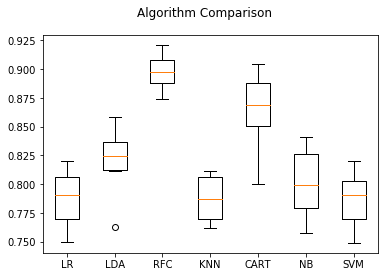

In [393]:
results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=10)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

Comme on peut le voir, Random Forest Classifier a la meilleure performance donc c'est notre choix pour appliquer avec les données traininig et tester nos données pour faire des prévisions.

### Elaboration du score avec l'algorithme de Foret aléatoire et ses paramètres optimal

Utilisation de la valeur optimale

In [394]:
print(1-credit_forest_optimal.oob_score_)
# erreur de prévision sur le test
1-credit_forest_optimal.score(X_test,y_test)
# prévision
y_chap = credit_forest_optimal.predict(X_test)
# matrice de confusion
table=pd.crosstab(y_test,y_chap)
print(table)

0.1006683375104428
col_0           0    1
incident_oui          
0             941   21
1              81  137


Et pour la dernière étape, nous comparons nos prédictions à la vérité.

In [395]:
print(accuracy_score(y_test, y_chap))
print(confusion_matrix(y_test, y_chap))
print(classification_report(y_test, y_chap))

0.9135593220338983
[[941  21]
 [ 81 137]]
              precision    recall  f1-score   support

           0       0.92      0.98      0.95       962
           1       0.87      0.63      0.73       218

    accuracy                           0.91      1180
   macro avg       0.89      0.80      0.84      1180
weighted avg       0.91      0.91      0.91      1180



Nous obtenons la précision de l'algorithme RandomForestClassifier sur nos valeurs. Les éléments pertinents ou les vrais positifs et les faux négatifs sont les bonnes prévisions.

In [396]:
#from sklearn.ensemble import RandomForestClassifier
#model = RandomForestClassifier()
credit_forest_optimal.fit(X, y)
pd.DataFrame({'Variable':X.columns,
              'Importance':credit_forest_optimal.feature_importances_}).sort_values('Importance', ascending=False)

,Variable,Importance
8,ratio,0.205380
6,agecredit,0.122053
0,pret,0.106121
5,nblitige,0.105813
2,propriete,0.105800
1,hypotheque,0.095441
3,experience,0.075903
4,nbreport,0.069423
7,nbcredit,0.053470
9,motif_HomeImp,0.015876


aleatoire: ROC AUC=0.500
Random Forest: ROC AUC=1.000


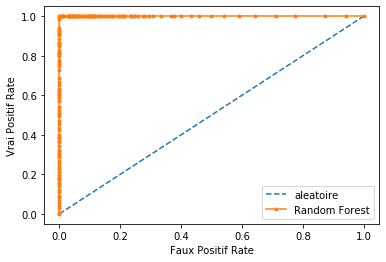

In [397]:
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot
# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(y_test))]
# predict probabilities
y_predit = forest_optimal.predict_proba(X_test)
# keep probabilities for the positive outcome only
y_predit = y_predit[:, 1]
# calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, y_predit)
# summarize scores
print('aleatoire: ROC AUC=%.3f' % (ns_auc))
print('Random Forest: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, y_predit)
# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='aleatoire')
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Random Forest')
# axis labels
pyplot.xlabel('Faux Positif Rate')
pyplot.ylabel('Vrai Positif Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

### *Le modèle est parait !!!!*

### SCORE

In [399]:
#calcul des probabilites d'affectation sur l'echantillon test
probabilite = forest_optimal.predict_proba(X_test)
#score de "Oui"
score = probabilite[:,1]

In [400]:
moyenne=score.mean()
maximum=score.max()
minimum=score.min()
grille100=100*((score-minimum)/(maximum-minimum))

In [401]:
data_y_test = pd.DataFrame(np.array(y_test))
data_X_test = pd.DataFrame(np.array(X_test))
#on obtient la table avec les X et Y test
data_test = pd.concat([data_X_test, data_y_test], axis=1)

In [402]:
data_test.columns = ['pret', 'hypotheque', 'propriete', 'experience', 'nbreport', 'nblitige',
       'agecredit', 'nbcredit', 'ratio', 'motif_HomeImp', 'profession_Office',
       'profession_Other', 'profession_ProfEx', 'profession_Sales',
       'profession_Self', 'incident_oui']
data_test.head()

,pret,hypotheque,propriete,experience,nbreport,nblitige,agecredit,nbcredit,ratio,motif_HomeImp,profession_Office,profession_Other,profession_ProfEx,profession_Sales,profession_Self,incident_oui
0,11900.0,83877.0,208924.0,15.0,0.0,0.0,1.062500,1.185911,18.250000,1.0,0.0,0.0,0.0,0.0,1.0,0
1,13000.0,41193.0,58000.0,18.0,3.0,2.0,5.577500,4.000000,33.630728,0.0,0.0,1.0,0.0,0.0,0.0,1
2,18000.0,39005.0,60000.0,10.0,2.0,0.0,9.385833,5.000000,33.630728,0.0,0.0,1.0,0.0,0.0,0.0,1
3,22100.0,95351.0,117905.0,25.0,0.0,0.0,19.479167,1.000000,41.524000,0.0,0.0,1.0,0.0,0.0,0.0,0
4,6200.0,45356.0,82054.0,2.0,0.0,0.0,16.777500,4.000000,29.662000,0.0,0.0,1.0,0.0,0.0,0.0,0


In [403]:
#on ajoute la colonne score (c'est à dire les probabilités)
data_test['score']=score
#on ajoute la variable grille100
data_test['grille100']=grille100
# on tri
data_test_sorted = data_test.sort_values("grille100", ascending=True)
# creation d'une variable rang qui donne le rank 
data_test_sorted["Rang"] = data_test_sorted["grille100"].rank()

In [404]:
data_test_sorted.head()

,pret,hypotheque,propriete,experience,nbreport,nblitige,agecredit,nbcredit,ratio,motif_HomeImp,profession_Office,profession_Other,profession_ProfEx,profession_Sales,profession_Self,incident_oui,score,grille100,Rang
942,22800.0,74081.562484,146840.0,8.962072,0.260579,0.454658,15.063853,1.185911,14.800,0.0,0.0,1.0,0.0,0.0,0.0,0,0.0,0.0,29.0
272,24100.0,104442.000000,161366.0,14.000000,0.000000,0.000000,16.303333,0.000000,34.541,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,29.0
712,21200.0,63093.000000,101789.0,18.000000,0.000000,0.000000,51.955000,1.000000,19.415,1.0,0.0,0.0,1.0,0.0,0.0,0,0.0,0.0,29.0
241,19300.0,146465.000000,192854.0,13.000000,0.260579,0.454658,9.220833,1.000000,29.976,0.0,0.0,0.0,1.0,0.0,0.0,0,0.0,0.0,29.0
384,21100.0,81389.000000,123842.0,9.000000,0.000000,0.000000,23.754167,1.000000,37.139,0.0,0.0,1.0,0.0,0.0,0.0,0,0.0,0.0,29.0


In [405]:
data_test_sorted['Rang'].min()
#il y a donc 29 personne qui sont de rang 1

29.0

### Partition du score

In [406]:
def conditions(s):
    if (s['score'] > 0.6666) :
        return "très risqué"
    if (0.3333 < s['score'] <= 0.6666) :
        return "Plus ou moins risqué"
    if (s['score'] <= 0.3333):
        return "peu risqué"
data_test_sorted['Class'] = data_test_sorted.apply(conditions, axis=1)

In [407]:
data_test_sorted.Class.value_counts()

peu risqué              962
très risqué             214
Plus ou moins risqué      4
Name: Class, dtype: int64

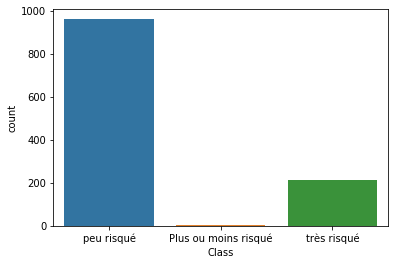

In [408]:
sns.countplot(x="Class", data=data_test_sorted)
plt.show()